In [2]:
import numpy as np
import os
import pandas as pd

BASE_DIR = r'C:\Users\HP\OneDrive\Desktop\UCI HAR Dataset'

SENSOR_FILES = [
    'body_acc_x_', 'body_acc_y_', 'body_acc_z_',
    'body_gyro_x_', 'body_gyro_y_', 'body_gyro_z_',
    'total_acc_x_', 'total_acc_y_', 'total_acc_z_'
]

def load_signals(signal_type='train'):
    """
    Loads raw sensor signal data from the Inertial Signals folder.
    Returns: (samples, time_steps, 9 features)
    """
    folder = os.path.join(BASE_DIR, signal_type, 'Inertial Signals')
    data = []
    
    for sensor in SENSOR_FILES:
        filename = sensor + signal_type + '.txt'
        file_path = os.path.join(folder, filename)

        signal = np.loadtxt(file_path)
        data.append(signal)

    data = np.array(data)
    data = np.transpose(data, (1, 2, 0))  # (samples, 128, 9)
    return data

def load_labels(signal_type='train'):
    """
    Loads activity labels (1 to 6) and converts them to 0 to 5.
    """
    file_path = os.path.join(BASE_DIR, signal_type, 'y_' + signal_type + '.txt')
    labels = np.loadtxt(file_path).astype(int) - 1
    return labels

# Load data
X_train = load_signals('train')
y_train = load_labels('train')
X_test = load_signals('test')
y_test = load_labels('test')

# Print shapes
print("X_train shape:", X_train.shape)  # (7352, 128, 9)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Sample DataFrame after loading X_train
sample_df = pd.DataFrame(X_train[0], columns=[
    'body_acc_x', 'body_acc_y', 'body_acc_z',
    'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
    'total_acc_x', 'total_acc_y', 'total_acc_z'
])

print("First label:", y_train[0])
print(sample_df.head())

# Normalize
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train_norm = (X_train - mean) / std
X_test_norm = (X_test - mean) / std

# One-hot encoding
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train, num_classes=6)
y_test_cat = to_categorical(y_test, num_classes=6)


X_train shape: (7352, 128, 9)
y_train shape: (7352,)
X_test shape: (2947, 128, 9)
y_test shape: (2947,)
First label: 4
   body_acc_x  body_acc_y  body_acc_z  body_gyro_x  body_gyro_y  body_gyro_z  \
0    0.000181    0.010767    0.055561     0.030191     0.066014     0.022859   
1    0.010139    0.006579    0.055125     0.043711     0.042699     0.010316   
2    0.009276    0.008929    0.048405     0.035688     0.074850     0.013250   
3    0.005066    0.007489    0.049775     0.040402     0.057320     0.017751   
4    0.010810    0.006141    0.043013     0.047097     0.052343     0.002553   

   total_acc_x  total_acc_y  total_acc_z  
0     1.012817    -0.123217     0.102934  
1     1.022833    -0.126876     0.105687  
2     1.022028    -0.124004     0.102102  
3     1.017877    -0.124928     0.106553  
4     1.023680    -0.125767     0.102814  


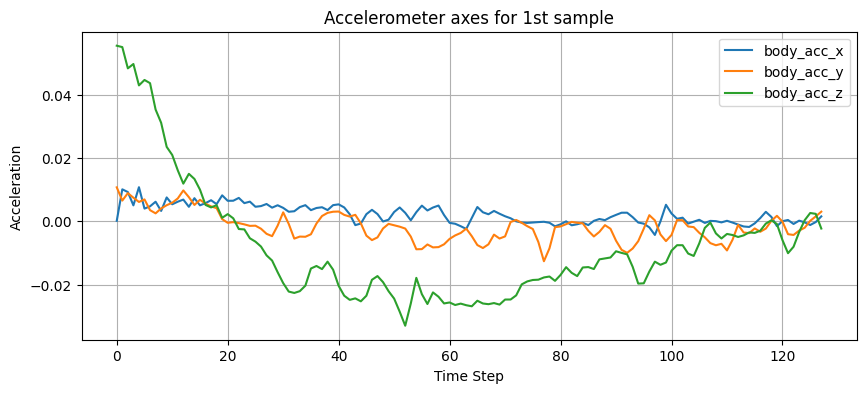

In [3]:
import matplotlib.pyplot as plt

# Plot accelerometer X/Y/Z for first sample
plt.figure(figsize=(10, 4))
plt.plot(X_train[0, :, 0], label='body_acc_x')
plt.plot(X_train[0, :, 1], label='body_acc_y')
plt.plot(X_train[0, :, 2], label='body_acc_z')
plt.legend()
plt.title("Accelerometer axes for 1st sample")
plt.xlabel("Time Step")
plt.ylabel("Acceleration")
plt.grid(True)
plt.show()


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
model = Sequential()

# Layer 1: Conv1D layer to extract local patterns
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(128, 9)))

# Layer 2: MaxPooling to reduce size and focus on strong features
model.add(MaxPooling1D(pool_size=2))

# Layer 3: Another Conv1D layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))

# Layer 4: Flatten the 3D output to 1D
model.add(Flatten())

# Layer 5: Fully connected (dense) layer
model.add(Dense(64, activation='relu'))

# Optional: Dropout to prevent overfitting
model.add(Dropout(0.5))

# Layer 6: Output layer (6 activity classes)
model.add(Dense(6, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train_norm, y_train_cat,
    epochs=15,
    batch_size=64,
    validation_data=(X_test_norm, y_test_cat)
)

loss, accuracy = model.evaluate(X_test_norm, y_test_cat)
print("Test Accuracy:", accuracy)


Epoch 1/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.6478 - loss: 0.9047 - val_accuracy: 0.9165 - val_loss: 0.2536
Epoch 2/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9307 - loss: 0.1817 - val_accuracy: 0.9148 - val_loss: 0.2892
Epoch 3/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9463 - loss: 0.1294 - val_accuracy: 0.9145 - val_loss: 0.2816
Epoch 4/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9505 - loss: 0.1156 - val_accuracy: 0.9148 - val_loss: 0.2740
Epoch 5/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9577 - loss: 0.1005 - val_accuracy: 0.9209 - val_loss: 0.3112
Epoch 6/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9482 - loss: 0.1087 - val_accuracy: 0.9121 - val_loss: 0.3349
Epoch 7/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9526 - loss: 0.1022 - val_accuracy: 0.9257 - val_loss: 0.3284
Epoch 8/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9500 - loss: 0.0977 - val_accu